In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import numpy as np
import re
from difflib import SequenceMatcher
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

##**Final Evaluation Codes**

The following codes contain the functions to run the text-based and span based evaluations and produce the results dataframe for onward plotting.

In [3]:
def is_relevant(retrieved_chunk, ground_truth, threshold=0.6):
    """ Returns True if retrieved text closely matches any ground truth answer. """
    for gt in ground_truth:
        if retrieved_chunk["filepath"] == gt["file_path"]:
            similarity = SequenceMatcher(None, retrieved_chunk["text"], gt["answer"]).ratio()
            if similarity > threshold:
                return True
    return False

def text_precision_recall(top_k_chunks, ground_truth, k):
    """
    Computes Precision and Recall based on text similarity.
    Args:
        top_k_chunks (list): List of retrieved chunks filtered by the chosen top-k.
        ground_truth (list): List of ground truth snippets.
        k (int): The value of k for precision and recall.
    """
    relevant = 0
    for chunk in top_k_chunks:
      relevant += 1 if is_relevant(chunk, ground_truth) else 0

    precision = relevant / k
    recall = relevant / len(ground_truth) if len(ground_truth) > 0 else 0

    return precision, recall

def span_precision_recall(top_k_chunks, ground_truth):
    """
    Computes precision and recall based on span overlap.
    Args:
        top_k_chunks (list): List of retrieved chunks filtered by the chosen top-k.
        ground_truth (list): List of ground truth snippets.
    """
    total_retrieved_len = 0
    relevant_retrieved_len = 0
    total_relevant_len = 0

    for chunk in top_k_chunks:
        total_retrieved_len += chunk["span"][1] - chunk["span"][0]
        for gt_snippet in ground_truth:
            if chunk["filepath"] == gt_snippet["file_path"]:
                common_min = max(chunk["span"][0], gt_snippet["span"][0])
                common_max = min(chunk["span"][1], gt_snippet["span"][1])
                if common_max > common_min:
                    relevant_retrieved_len += common_max - common_min

    for gt_snippet in ground_truth:
        total_relevant_len += gt_snippet["span"][1] - gt_snippet["span"][0]

    precision = relevant_retrieved_len / total_retrieved_len if total_retrieved_len > 0 else 0
    recall = relevant_retrieved_len / total_relevant_len if total_relevant_len > 0 else 0
    return precision, recall

def evaluate_and_create_dataframe(json_file_path, k_values):
    """Evaluates and creates a DataFrame with precision and recall (text and span)."""
    with open(json_file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    results = []
    for index, test in enumerate(data):
        ground_truth = test["snippets"]
        unranked_chunks = test["retrieved_chunks_unranked"]
        reranked_chunks = test["retrieved_chunks_ranked"]

        for k in k_values:
            # Text-based evaluation (by passing top-k chunks)
            unranked_text_precision, unranked_text_recall = text_precision_recall(unranked_chunks[:k], ground_truth, k)
            reranked_text_precision, reranked_text_recall = text_precision_recall(reranked_chunks[:k], ground_truth, k)

            # Span-based evaluation (by passing top-k chunks)
            unranked_span_precision, unranked_span_recall = span_precision_recall(unranked_chunks[:k], ground_truth)
            reranked_span_precision, reranked_span_recall = span_precision_recall(reranked_chunks[:k], ground_truth)

            results.append({
                "query_index": index,
                "k": k,
                "unranked_text_precision": unranked_text_precision,
                "unranked_text_recall": unranked_text_recall,
                "reranked_text_precision": reranked_text_precision,
                "reranked_text_recall": reranked_text_recall,
                "unranked_span_precision": unranked_span_precision,
                "unranked_span_recall": unranked_span_recall,
                "reranked_span_precision": reranked_span_precision,
                "reranked_span_recall": reranked_span_recall
            })

    return pd.DataFrame(results)

###**Execution Codes**

Select the source folder which will contain all the experiments to be evaluated. The source folder should contain subfolders with the experiment names and in each subfolder, there should be 4 json files ['privacy_qa.json', 'cuad.json', 'maud.json', 'contractnli.json'].

In [4]:
# Main Execution
if __name__ == "__main__":
    base_folder = "/content/drive/My Drive/SNLP/new_runs"  # Replace with your folder path that contains the runs for evaluation
    k_values = [1, 2, 4, 8, 16, 32, 50]     #Adjust the k-values as per your comparison framework
    all_dfs = []

    experiment_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    for experiment_folder in experiment_folders:
        experiment_path = os.path.join(base_folder, experiment_folder)
        json_files = [f for f in os.listdir(experiment_path) if f.endswith(".json")]

        print(f"Checking folder: {experiment_path}") #Debug print
        print(f"Found JSON files: {json_files}") #Debug print

        experiment_dfs = []

        for json_file in json_files:
            json_file_path = os.path.join(experiment_path, json_file)
            print(f"Processing JSON file: {json_file_path}") #Debug print

            try:
                df = evaluate_and_create_dataframe(json_file_path, k_values)
                df["type"] = json_file.replace("sampled_queries_", "").replace(".json", "")
                df["experiment_title"] = experiment_folder
                experiment_dfs.append(df)
            except Exception as e:
                print(f"Error processing {json_file_path}: {e}")

        if experiment_dfs: #Check if any dataframes were created.
            experiment_df = pd.concat(experiment_dfs)
            all_dfs.append(experiment_df)
            print(f"Successfully processed experiment: {experiment_folder}") #Debug print.
        else:
            print(f"No dataframes created for {experiment_folder}") #Debug print.

Checking folder: /content/drive/My Drive/SNLP/new_runs/3_Naive_DSbert_Cosine
Found JSON files: ['privacy_qa.json', 'cuad.json', 'maud.json', 'contractnli.json']
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/3_Naive_DSbert_Cosine/privacy_qa.json
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/3_Naive_DSbert_Cosine/cuad.json
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/3_Naive_DSbert_Cosine/maud.json
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/3_Naive_DSbert_Cosine/contractnli.json
Successfully processed experiment: 3_Naive_DSbert_Cosine
Checking folder: /content/drive/My Drive/SNLP/new_runs/5_Naive_GTE_Cosine
Found JSON files: ['privacy_qa.json', 'cuad.json', 'maud.json', 'contractnli.json']
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/5_Naive_GTE_Cosine/privacy_qa.json
Processing JSON file: /content/drive/My Drive/SNLP/new_runs/5_Naive_GTE_Cosine/cuad.json
Processing JSON file: /content/drive/My Drive/SNLP/new_runs

##**Interactive plots**

In [10]:
# Interactive plots
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_experiment_metrics_plotly(dfs, k_values):
    """Plots precision and recall vs k for each experiment, ranked and unranked using Plotly."""
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=("Recall@K (Span) vs K for Each Experiment", "Precision@K (Span) vs K for Each Experiment"),
                        shared_xaxes=True)

    # Define a color map for consistent experiment colors
    unique_experiments = sorted(set(df["experiment_title"].iloc[0] for df in dfs))
    color_map = {exp: f"rgba({np.random.randint(50,255)},{np.random.randint(50,255)},{np.random.randint(50,255)},1)" for exp in unique_experiments}

    for df in dfs:
        experiment_title = df["experiment_title"].iloc[0]
        numeric_cols = df.select_dtypes(include=np.number).columns
        avg_ranked = df.groupby('k')[numeric_cols].mean()

        color = color_map[experiment_title]

        # Recall (Row 1)
        fig.add_trace(go.Scatter(
            x=k_values, y=avg_ranked["reranked_span_recall"],
            mode='lines', name=f"{experiment_title} (Ranked)",
            line=dict(dash='solid', color=color),
            legendgroup=experiment_title),  # Assign legend group
            row=1, col=1
        )

        fig.add_trace(go.Scatter(
            x=k_values, y=avg_ranked["unranked_span_recall"],
            mode='lines', name=f"{experiment_title} (Unranked)",
            line=dict(dash='dash', color=color),
            legendgroup=experiment_title),  # Assign legend group
            row=1, col=1
        )

        # Precision (Row 2) - Hide duplicate legends using `showlegend=False`
        fig.add_trace(go.Scatter(
            x=k_values, y=avg_ranked["reranked_span_precision"],
            mode='lines', name=f"{experiment_title} (Ranked)",
            line=dict(dash='solid', color=color),
            legendgroup=experiment_title, showlegend=False),  # Hide duplicate legend
            row=2, col=1
        )

        fig.add_trace(go.Scatter(
            x=k_values, y=avg_ranked["unranked_span_precision"],
            mode='lines', name=f"{experiment_title} (Unranked)",
            line=dict(dash='dash', color=color),
            legendgroup=experiment_title, showlegend=False),  # Hide duplicate legend
            row=2, col=1
        )

    fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values)-1, max(k_values) + 1, 2), row=1, col=1)
    fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values)-1, max(k_values) + 1, 2), row=2, col=1)

    # Update layout with a common legend
    fig.update_layout(
        showlegend=True,
        legend=dict(x=1, y=1),  # Position the legend in the top-right
        height=1000, width=1000, title_text="Experiment Metrics"
    )

    fig.show()

def plot_type_metrics_plotly(dfs, k_values):
    """Plots precision and recall vs k for each type, showing experiment performance using Plotly."""
    types = ["contractnli", "cuad", "maud", "privacy_qa"]

    # Define a color map for consistent experiment colors
    unique_experiments = sorted(set(df["experiment_title"].iloc[0] for df in dfs))
    color_map = {exp: f"rgba({np.random.randint(50,255)},{np.random.randint(50,255)},{np.random.randint(50,255)},1)" for exp in unique_experiments}


    for data_type in types:
        type_dfs = [df[df['type'] == data_type] for df in dfs]

        fig = make_subplots(rows=2, cols=1,
                        subplot_titles=(f"Recall@K (Span) vs K for Each Experiment for {data_type}", f"Precision@K (Span) vs K for Each Experiment for {data_type}"),
                        shared_xaxes=True)

        for df in type_dfs:
            experiment_title = df["experiment_title"].iloc[0]
            numeric_cols = df.select_dtypes(include=np.number).columns
            avg_ranked = df.groupby('k')[numeric_cols].mean()

            color = color_map[experiment_title]

            # Recall (Row 1)
            fig.add_trace(go.Scatter(
                x=k_values, y=avg_ranked["reranked_span_recall"],
                mode='lines', name=f"{experiment_title} (Ranked)",
                line=dict(dash='solid', color=color),
                legendgroup=experiment_title),  # Assign legend group
                row=1, col=1
            )

            fig.add_trace(go.Scatter(
                x=k_values, y=avg_ranked["unranked_span_recall"],
                mode='lines', name=f"{experiment_title} (Unranked)",
                line=dict(dash='dash', color=color),
                legendgroup=experiment_title),  # Assign legend group
                row=1, col=1
            )

            # Precision (Row 2) - Hide duplicate legends using `showlegend=False`
            fig.add_trace(go.Scatter(
                x=k_values, y=avg_ranked["reranked_span_precision"],
                mode='lines', name=f"{experiment_title} (Ranked)",
                line=dict(dash='solid', color=color),
                legendgroup=experiment_title, showlegend=False),  # Hide duplicate legend
                row=2, col=1
            )

            fig.add_trace(go.Scatter(
                x=k_values, y=avg_ranked["unranked_span_precision"],
                mode='lines', name=f"{experiment_title} (Unranked)",
                line=dict(dash='dash', color=color),
                legendgroup=experiment_title, showlegend=False),  # Hide duplicate legend
                row=2, col=1
            )

         # Update x-axis ticks
        fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values), max(k_values) + 1, 2), row=1, col=1)
        fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values), max(k_values) + 1, 2), row=2, col=1)

        # Update layout with a common legend
        fig.update_layout(
            showlegend=True,
            legend=dict(x=1, y=1),  # Position the legend in the top-right
            height=1000, width=1000, title_text="Experiment Metrics"
        )

        fig.show()

In [6]:
plot_experiment_metrics_plotly(all_dfs, k_values)

In [11]:
plot_type_metrics_plotly(all_dfs, k_values)

In [8]:
def plot_experiment_metrics_plotly(dfs, k_values):
    """Plots precision and recall vs k for each experiment, ranked and unranked using Plotly."""
    fig = make_subplots(rows=2, cols=1,
                        subplot_titles=("Recall@K (Span) vs K for Each Experiment", "Precision@K (Span) vs K for Each Experiment"),
                        shared_xaxes=True)

    # Get unique experiment names and sort them in ascending order
    unique_experiments = sorted(set(df["experiment_title"].iloc[0] for df in dfs))  # ✅ Sorting here

    # Define a color map with sorted order
    color_map = {exp: f"rgba({np.random.randint(50,255)},{np.random.randint(50,255)},{np.random.randint(50,255)},1)" for exp in unique_experiments}

    for exp in unique_experiments:  # ✅ Loop through sorted experiments
        for df in dfs:
            if df["experiment_title"].iloc[0] == exp:  # Match only relevant experiment data
                numeric_cols = df.select_dtypes(include=np.number).columns
                avg_ranked = df.groupby('k')[numeric_cols].mean()

                color = color_map[exp]  # Use consistent color for each experiment

                # Recall (Row 1)
                fig.add_trace(go.Scatter(
                    x=k_values, y=avg_ranked["reranked_span_recall"],
                    mode='lines', name=f"{exp} (Ranked)",
                    line=dict(dash='solid', color=color),
                    legendgroup=exp),  # Assign legend group
                    row=1, col=1,
                )

                fig.add_trace(go.Scatter(
                    x=k_values, y=avg_ranked["unranked_span_recall"],
                    mode='lines', name=f"{exp} (Unranked)",
                    line=dict(dash='dash', color=color),
                    legendgroup=exp),  # Assign legend group
                    row=1, col=1
                )

                # Precision (Row 2) - Hide duplicate legends using `showlegend=False`
                fig.add_trace(go.Scatter(
                    x=k_values, y=avg_ranked["reranked_span_precision"],
                    mode='lines', name=f"{exp} (Ranked)",
                    line=dict(dash='solid', color=color),
                    legendgroup=exp, showlegend=False),  # Hide duplicate legend
                    row=2, col=1
                )

                fig.add_trace(go.Scatter(
                    x=k_values, y=avg_ranked["unranked_span_precision"],
                    mode='lines', name=f"{exp} (Unranked)",
                    line=dict(dash='dash', color=color),
                    legendgroup=exp, showlegend=False),  # Hide duplicate legend
                    row=2, col=1
                )

    # Update x-axis ticks
    fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values), max(k_values) + 1, 1), row=1, col=1)
    fig.update_xaxes(tickmode='array', tickvals=np.arange(min(k_values), max(k_values) + 1, 1), row=2, col=1)

    # Update layout with a common legend, sorted
    fig.update_layout(
        showlegend=True,
        legend=dict(x=1, y=1),  # Position the legend in the top-right
        height=1000, width=1000, title_text="Experiment Metrics"
    )

    fig.show()

In [9]:
plot_experiment_metrics_plotly(all_dfs, k_values)

**Export Results**

In [ ]:
# Create an empty list to store summary DataFrames
summary_dfs = []
types = ["contractnli", "cuad", "maud", "privacy_qa"]

for data_type in types:
    # Filter DataFrames based on 'type'
    type_dfs = [df[df['type'] == data_type] for df in all_dfs]

    for df in type_dfs:
        experiment_title = df["experiment_title"].iloc[0]  # Extract the experiment title

        # Select numeric columns for aggregation
        numeric_cols = df.select_dtypes(include=np.number).columns

        # Compute mean Recall@K and Precision@K grouped by 'k'
        avg_ranked = df.groupby('k', as_index=False)[numeric_cols].mean()

        # Add experiment and data type metadata
        avg_ranked["experiment_title"] = experiment_title
        avg_ranked["data_type"] = data_type

        # Store in list
        summary_dfs.append(avg_ranked)

# Concatenate all results into a single DataFrame
summary_df = pd.concat(summary_dfs, ignore_index=True)

In [ ]:
summary_df

,query_index,k,unranked_text_precision,unranked_text_recall,reranked_text_precision,reranked_text_recall,unranked_span_precision,unranked_span_recall,reranked_span_precision,reranked_span_recall,experiment_title,data_type
0,96.5,1.0,0.025773,0.019759,0.010309,0.006873,0.036557,0.059462,0.027186,0.043324,3_Naive_DSbert_Cosine,contractnli
1,96.5,2.0,0.018041,0.030069,0.007732,0.012027,0.030387,0.085986,0.025304,0.076067,3_Naive_DSbert_Cosine,contractnli
2,96.5,4.0,0.011598,0.037801,0.010309,0.035223,0.024858,0.134131,0.022418,0.119102,3_Naive_DSbert_Cosine,contractnli
3,96.5,8.0,0.006443,0.040378,0.008376,0.053265,0.016916,0.170682,0.019027,0.185647,3_Naive_DSbert_Cosine,contractnli
4,96.5,16.0,0.003544,0.042955,0.005477,0.066151,0.010909,0.213302,0.013106,0.249136,3_Naive_DSbert_Cosine,contractnli
...,...,...,...,...,...,...,...,...,...,...,...,...
195,95.5,1.0,0.057292,0.026476,0.046875,0.017535,0.114253,0.062866,0.096881,0.041376,11_RCTS_GTE_Cosine,privacy_qa
196,95.5,2.0,0.049479,0.044010,0.046875,0.036136,0.101487,0.094841,0.092676,0.084768,11_RCTS_GTE_Cosine,privacy_qa
197,95.5,4.0,0.046875,0.094668,0.036458,0.058879,0.095653,0.185182,0.074043,0.133763,11_RCTS_GTE_Cosine,privacy_qa
198,95.5,8.0,0.040365,0.169494,0.030599,0.109598,0.077162,0.295460,0.056426,0.217027,11_RCTS_GTE_Cosine,privacy_qa


In [ ]:
#output the summary_df
summary_df.to_csv("summary_df.csv", index=False)

###**RetroMAE**

Modify the main execution to run RetroMAE vs our best model comparison. The source folder only contains 2 sub-folders: 1 for RCTS_RetroMAE_Cosine outputs and the other for RCTS_SBert_Cosine outputs.

In [ ]:
# Main Execution
if __name__ == "__main__":
    base_folder = "/content/drive/My Drive/SNLP/retromae"  # Replace with your base folder path
    k_values = [1, 2, 4, 8, 16]
    all_dfs = []

    experiment_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

    for experiment_folder in experiment_folders:
        experiment_path = os.path.join(base_folder, experiment_folder)
        json_files = [f for f in os.listdir(experiment_path) if f.endswith(".json")]

        print(f"Checking folder: {experiment_path}") #Debug print
        print(f"Found JSON files: {json_files}") #Debug print

        experiment_dfs = []

        for json_file in json_files:
            json_file_path = os.path.join(experiment_path, json_file)
            print(f"Processing JSON file: {json_file_path}") #Debug print

            try:
                df = evaluate_and_create_dataframe(json_file_path, k_values)
                df["type"] = json_file.replace("sampled_queries_", "").replace(".json", "")
                df["experiment_title"] = experiment_folder
                experiment_dfs.append(df)
            except Exception as e:
                print(f"Error processing {json_file_path}: {e}")

        if experiment_dfs: #Check if any dataframes were created.
            experiment_df = pd.concat(experiment_dfs)
            all_dfs.append(experiment_df)
            print(f"Successfully processed experiment: {experiment_folder}") #Debug print.
        else:
            print(f"No dataframes created for {experiment_folder}") #Debug print.

Checking folder: /content/drive/My Drive/SNLP/retromae/7_RCTS_SBert_Cosine
Found JSON files: ['sampled_queries_cuad.json', 'sampled_queries_maud.json', 'sampled_queries_contractnli.json']
Processing JSON file: /content/drive/My Drive/SNLP/retromae/7_RCTS_SBert_Cosine/sampled_queries_cuad.json
Processing JSON file: /content/drive/My Drive/SNLP/retromae/7_RCTS_SBert_Cosine/sampled_queries_maud.json
Processing JSON file: /content/drive/My Drive/SNLP/retromae/7_RCTS_SBert_Cosine/sampled_queries_contractnli.json
Successfully processed experiment: 7_RCTS_SBert_Cosine
Checking folder: /content/drive/My Drive/SNLP/retromae/13_RetroMAE
Found JSON files: ['sampled_queries_privacy_qa.json', 'sampled_queries_cuad.json', 'sampled_queries_contractnli.json', 'sampled_queries_maud.json']
Processing JSON file: /content/drive/My Drive/SNLP/retromae/13_RetroMAE/sampled_queries_privacy_qa.json
Processing JSON file: /content/drive/My Drive/SNLP/retromae/13_RetroMAE/sampled_queries_cuad.json
Processing JSON

In [ ]:
# Plot overall comparison plot for RetroMAE vs SBert
plot_experiment_metrics_plotly(all_dfs, k_values)

###**Simple Plots**

Previous graphs plotted with simpler layout. Maybe necessary for reports.

In [ ]:
def plot_experiment_metrics(dfs, k_values):
    """Plots precision and recall vs k for each experiment, ranked and unranked."""
    num_experiments = len(dfs)
    colors = plt.cm.get_cmap('viridis', num_experiments)

    plt.figure(figsize=(14, 12))

    # Recall vs K
    plt.subplot(2, 1, 1)
    for df in dfs:
        experiment_title = df["experiment_title"].iloc[0]
        numeric_cols = df.select_dtypes(include=np.number).columns #Select numeric columns.
        avg_ranked = df.groupby('k')[numeric_cols].mean() #Calculate mean of numeric columns.
        plt.plot(k_values, avg_ranked["reranked_text_recall"], label=f"{experiment_title} (Ranked)", linestyle='-')
        plt.plot(k_values, avg_ranked["unranked_text_recall"], label=f"{experiment_title} (Unranked)", linestyle='--')
    plt.xlabel("K")
    plt.ylabel("Recall@K (Text)")
    plt.title("Recall@K (Text) vs K for Each Experiment")
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))

    # Precision vs K
    plt.subplot(2, 1, 2)
    for df in dfs:
        experiment_title = df["experiment_title"].iloc[0]
        numeric_cols = df.select_dtypes(include=np.number).columns
        avg_ranked = df.groupby('k')[numeric_cols].mean()
        plt.plot(k_values, avg_ranked["reranked_text_precision"], label=f"{experiment_title} (Ranked)", linestyle='-')
        plt.plot(k_values, avg_ranked["unranked_text_precision"], label=f"{experiment_title} (Unranked)", linestyle='--')
    plt.xlabel("K")
    plt.ylabel("Precision@K (Text)")
    plt.title("Precision@K (Text) vs K for Each Experiment")
    plt.legend()
    plt.grid(True)
    plt.xticks(np.arange(min(k_values), max(k_values)+1, 1))

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_type_metrics(all_dfs, k_values):
    """Plots precision and recall vs k for each type, showing experiment performance."""
    types = ["contractnli", "cuad", "maud", "privacy_qa"]

    for data_type in types:
        type_dfs = [df[df['type'] == data_type] for df in all_dfs]

        plt.figure(figsize=(14, 12))

        # Recall vs K
        plt.subplot(2, 1, 1)
        for df in type_dfs:
            experiment_title = df["experiment_title"].iloc[0]
            numeric_cols = df.select_dtypes(include=np.number).columns
            avg_ranked = df.groupby('k')[numeric_cols].mean()
            plt.plot(k_values, avg_ranked["reranked_text_recall"], label=f"{experiment_title} (Ranked)", linestyle='-')
            plt.plot(k_values, avg_ranked["unranked_text_recall"], label=f"{experiment_title} (Unranked)", linestyle='--')
        plt.xlabel("K")
        plt.ylabel("Recall@K (Text)")
        plt.title(f"Recall@K (Text) vs K for {data_type}")
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))

        # Precision vs K
        plt.subplot(2, 1, 2)
        for df in type_dfs:
            experiment_title = df["experiment_title"].iloc[0]
            numeric_cols = df.select_dtypes(include=np.number).columns
            avg_ranked = df.groupby('k')[numeric_cols].mean()
            plt.plot(k_values, avg_ranked["reranked_text_precision"], label=f"{experiment_title} (Ranked)", linestyle='-')
            plt.plot(k_values, avg_ranked["unranked_text_precision"], label=f"{experiment_title} (Unranked)", linestyle='--')
        plt.xlabel("K")
        plt.ylabel("Precision@K (Text)")
        plt.title(f"Precision@K (Text) vs K for {data_type}")
        plt.legend()
        plt.grid(True)
        plt.xticks(np.arange(min(k_values), max(k_values)+1, 2))


        plt.tight_layout()
        plt.show()

<ipython-input-101-1fbd742632dd>:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



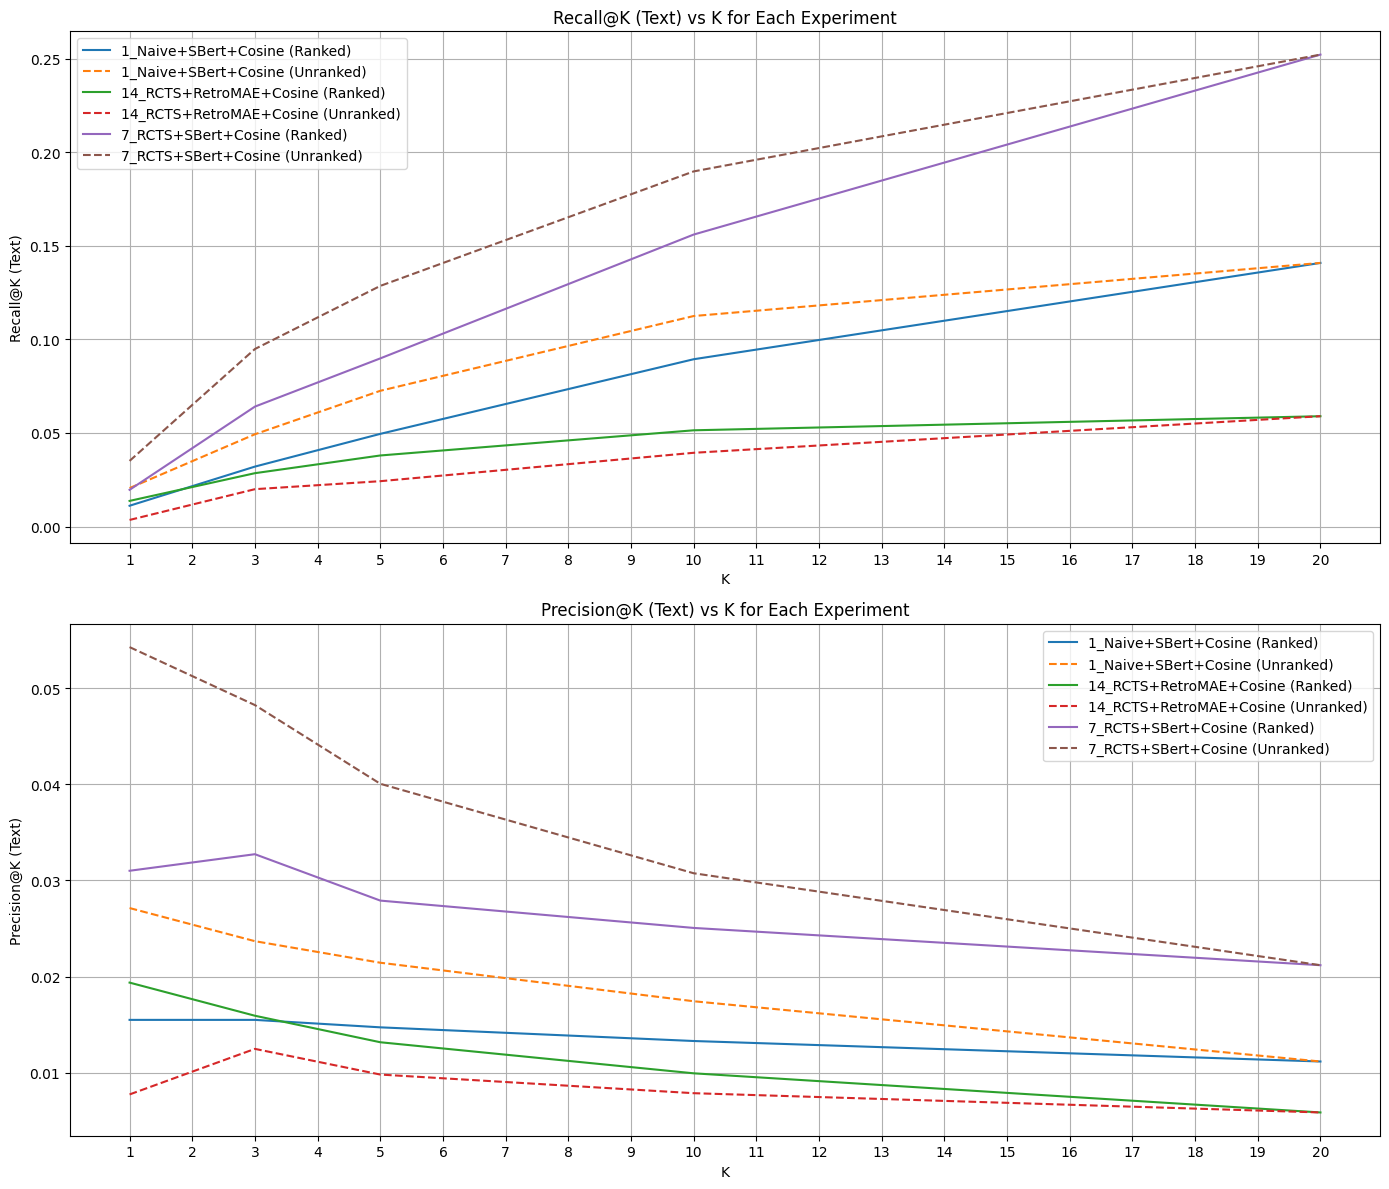

In [ ]:
# Simple plot - all experiments
plot_experiment_metrics(all_dfs, k_values)

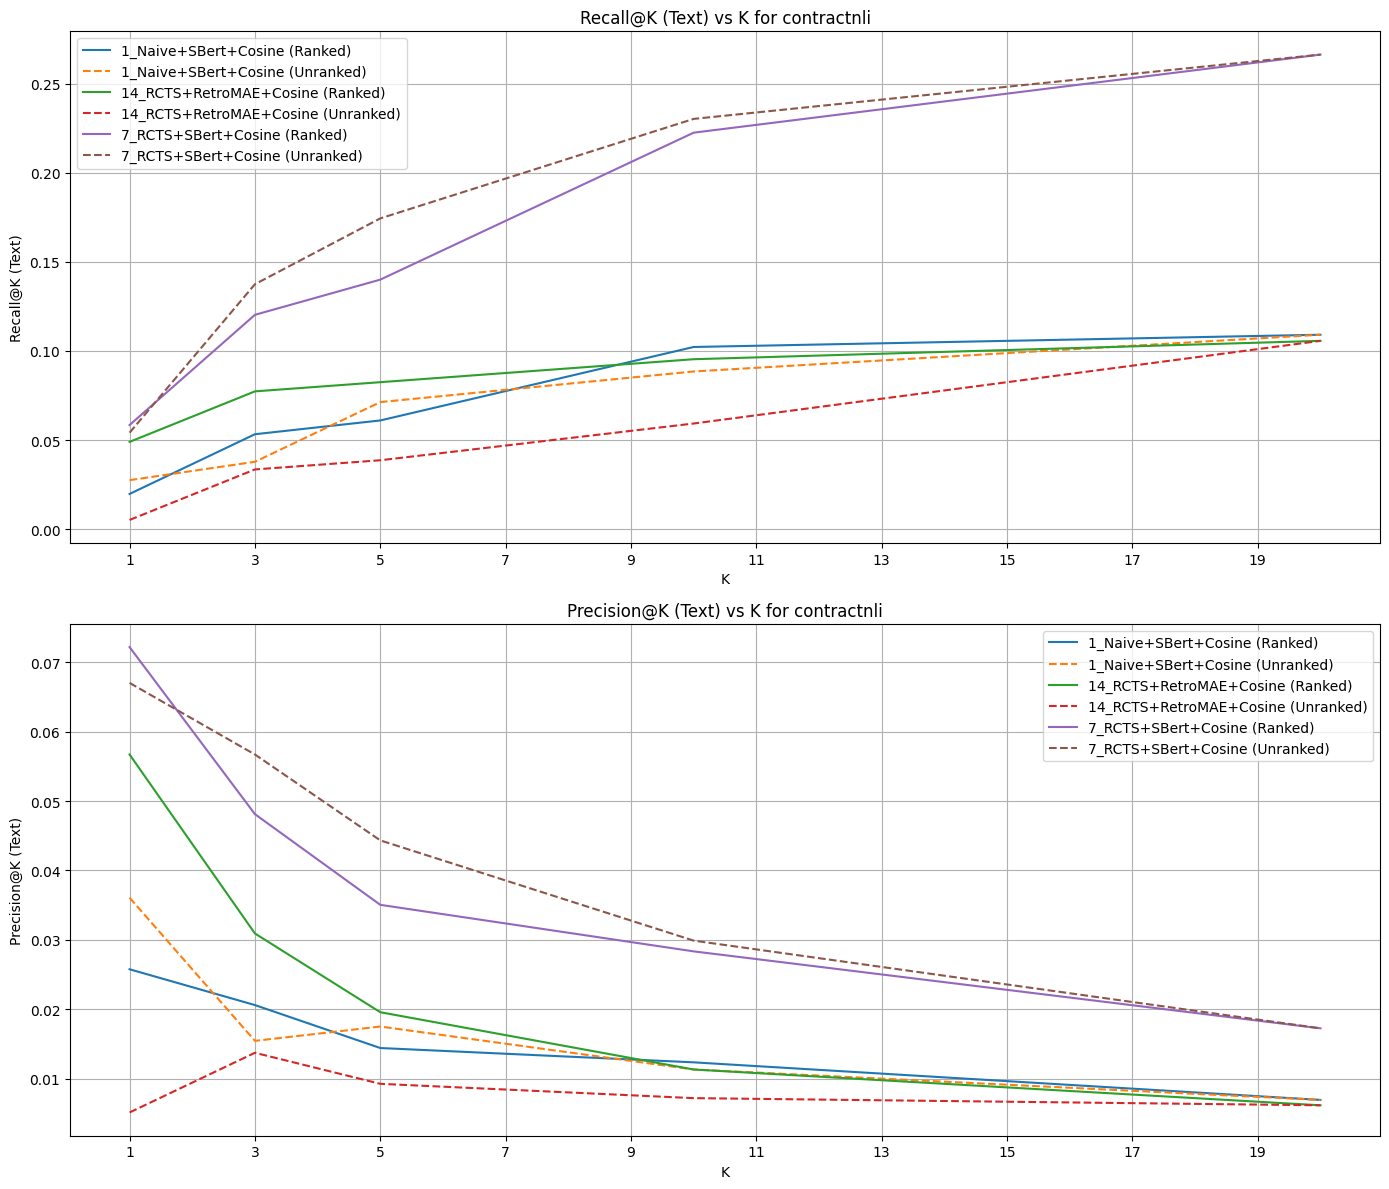

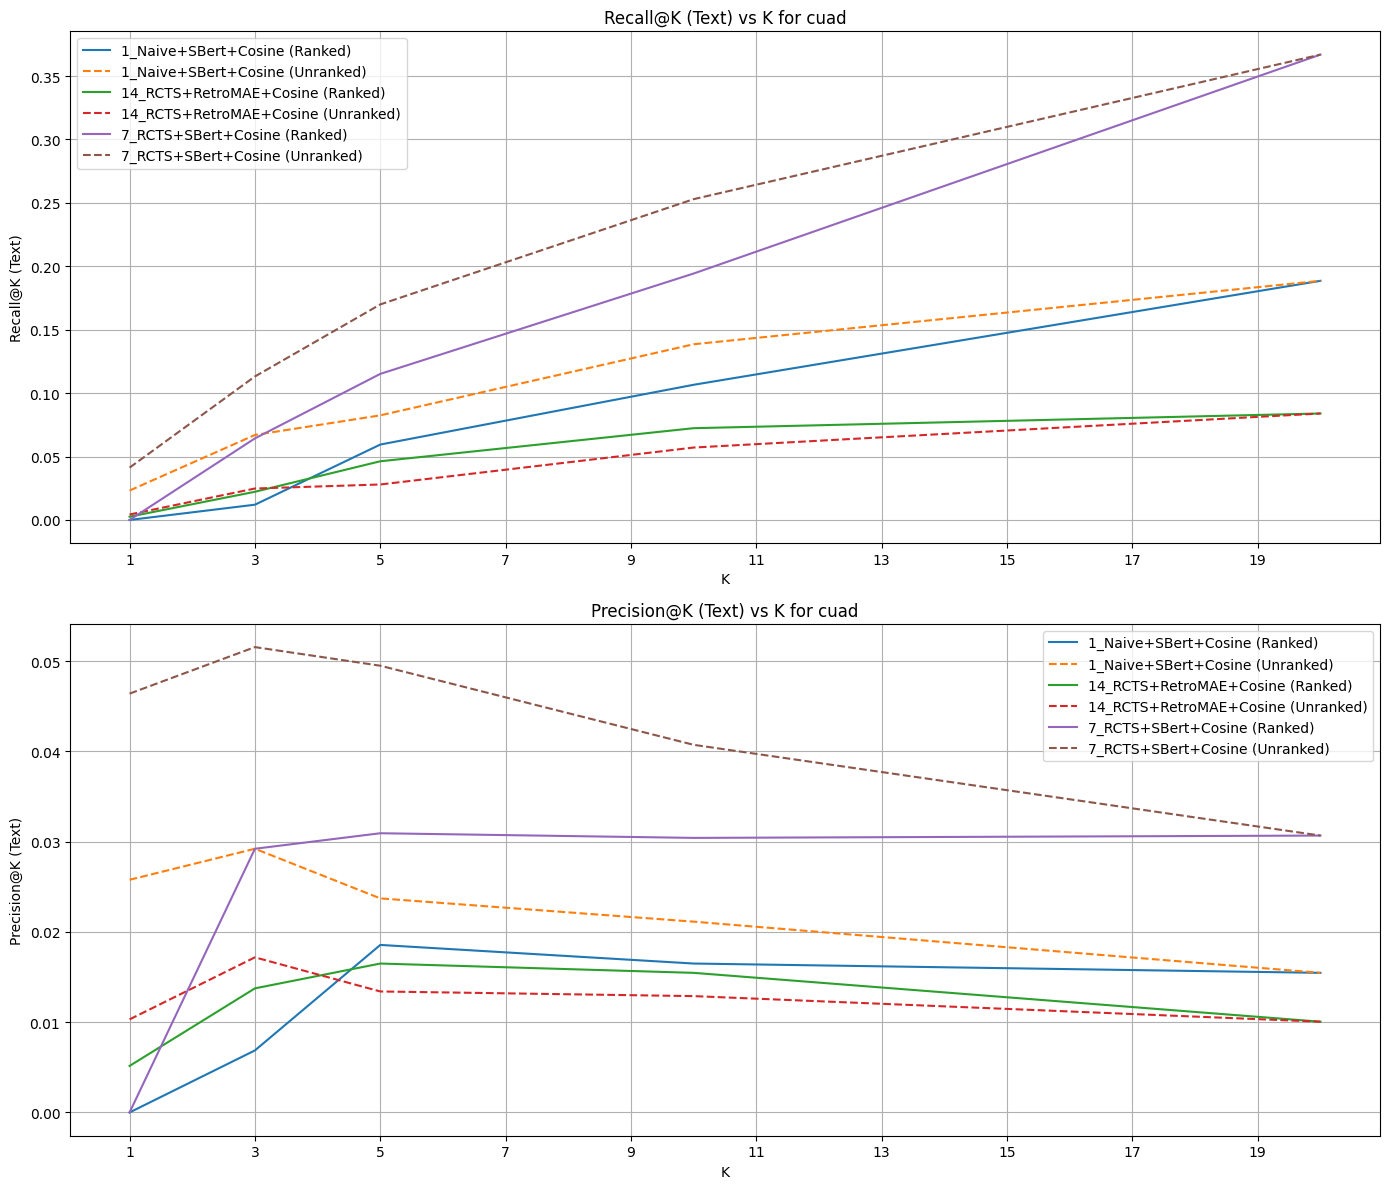

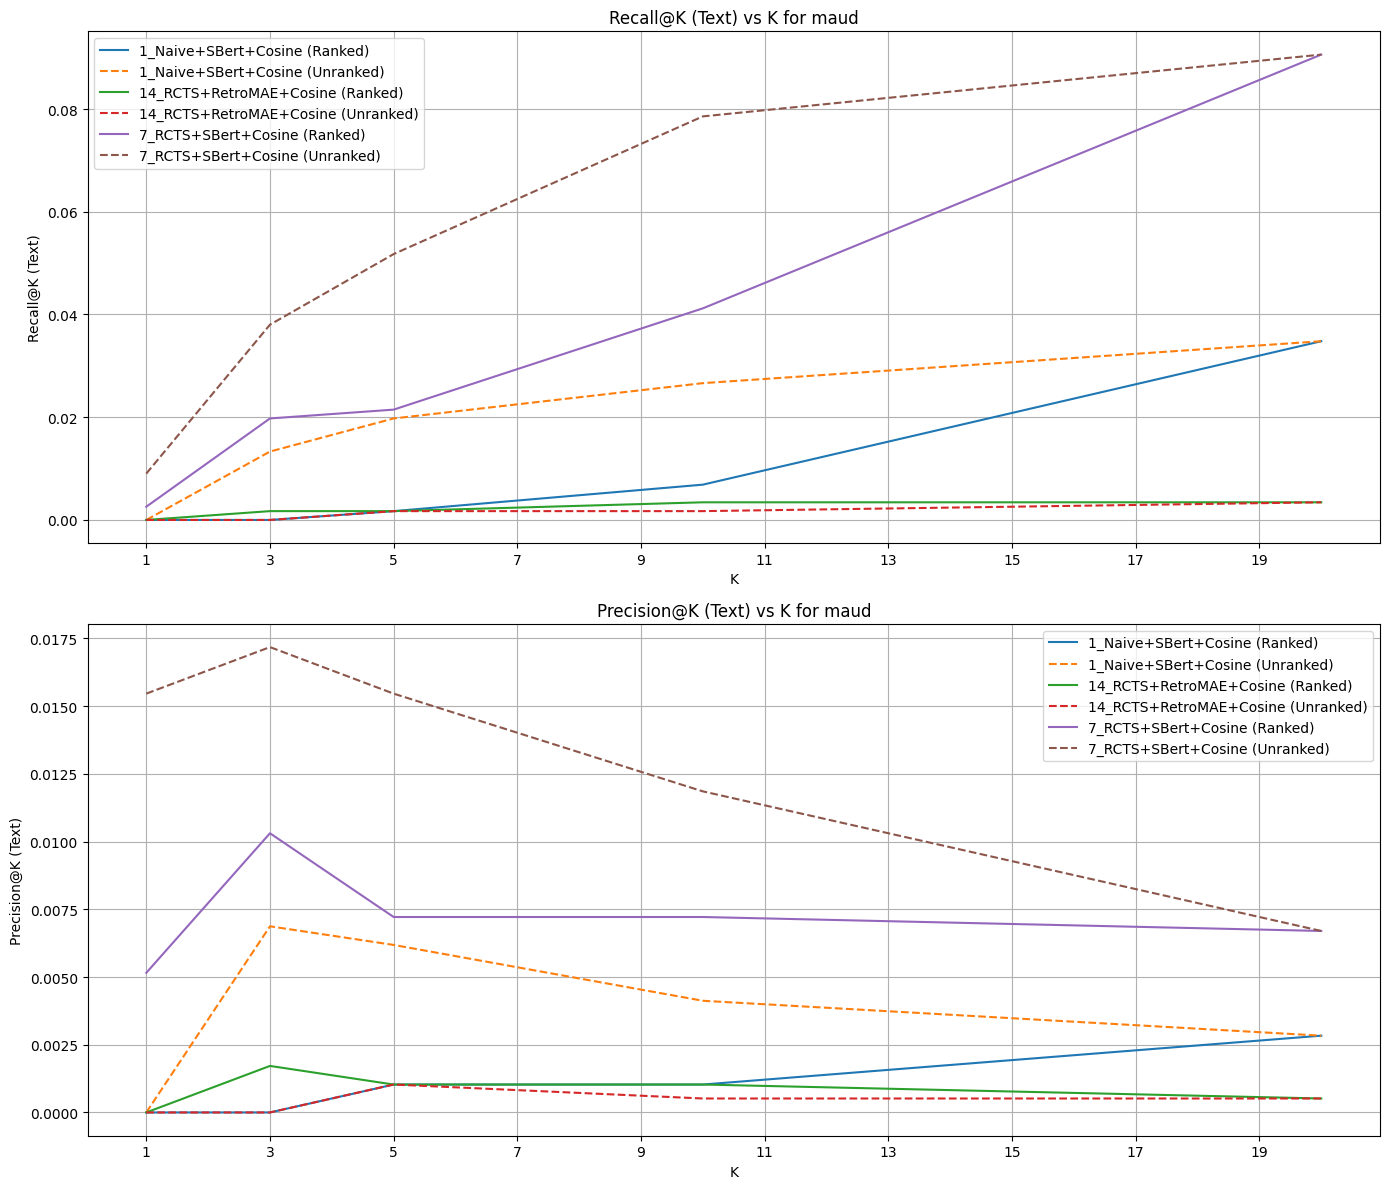

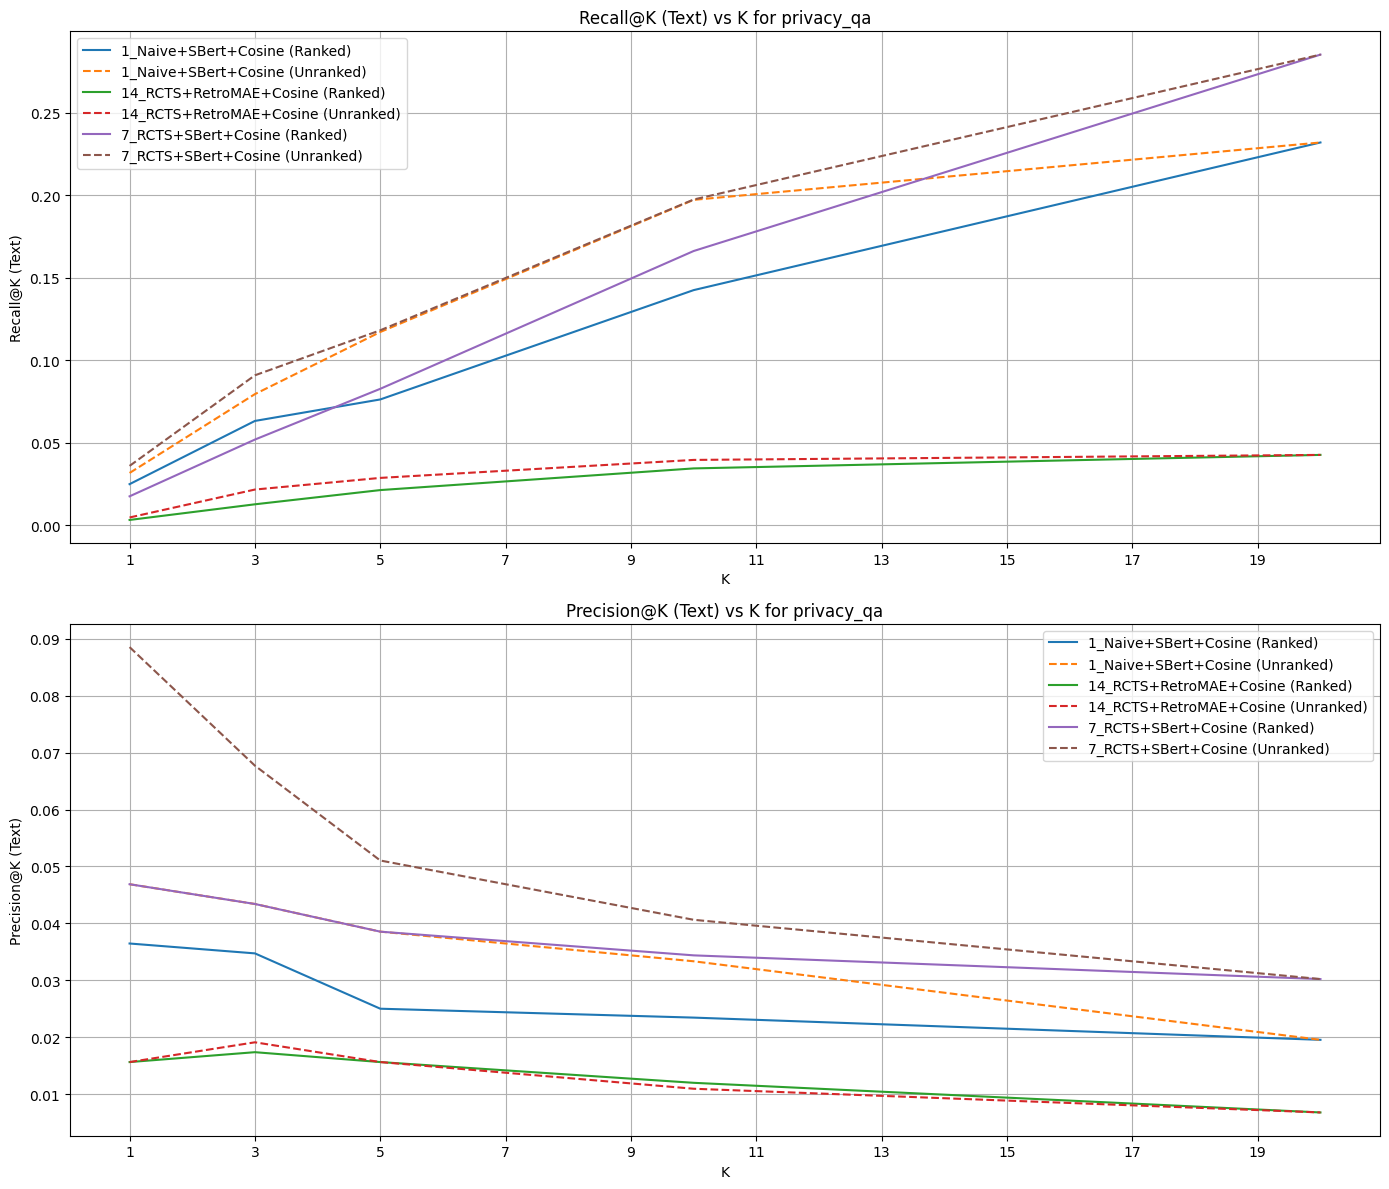

In [ ]:
plot_type_metrics(all_dfs, k_values)